# Prophet을 활용하여 금리 변동값을 통해 2024-01-01 이후 평균 전세값 예측하기
yhat 값을 사용하여 그래프를 그렸을 때, 금리에 과적합되는 그래프를 보임.

trend 값을 통해, 큰 흐름으로 전세값의 평균을 예측함.

In [474]:
import pandas as pd

In [475]:
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')
interest_rate_df = pd.read_csv('data/interestRate.csv')

In [476]:
# Train_df에서 contract_year_month가 같은 row들의 deposit 평균을 column으로 추가
train_df['deposit_mean'] = train_df.groupby('contract_year_month')['deposit'].transform('mean')

In [477]:
interest_rate_df['contract_year_month'] =interest_rate_df['year_month']
interest_rate_df.drop(['year_month'], axis=1, inplace=True)

In [478]:
# deposit_mean을 interest_rate_df에 추가 하나씩만
interest_rate_df = pd.merge(interest_rate_df, train_df[['contract_year_month', 'deposit_mean']], on='contract_year_month', how='left')

In [479]:
# unique한 contract_year_month만 남기기
interest_rate_df.drop_duplicates(subset='contract_year_month', keep='first', inplace=True)

In [480]:
# index 초기화
interest_rate_df.reset_index(drop=True, inplace=True)
# 2019 04 이후 데이터만 사용


In [481]:
# contract_year_month 202406 추가 하고 interest_rate 전부 shift 한칸씩
# AttributeError: 'DataFrame' object has no attribute 'append'
interest_rate_df = pd.concat([interest_rate_df, pd.DataFrame({'contract_year_month': [202406], 'interest_rate': [0]})])
# index는 contract_year_month로
interest_rate_df.set_index('contract_year_month', inplace=True)
# index 순서대로 정렬
interest_rate_df.sort_index(inplace=True)
interest_rate_df['interest_rate'] = interest_rate_df['interest_rate'].shift(4)

# 이전 금리와 차이값 feature 추가
interest_rate_df['interest_rate_diff'] = interest_rate_df['interest_rate'].diff()

In [482]:
# 2019 04 이후 데이터만 사용
interest_rate_df = interest_rate_df[interest_rate_df.index >= 201904]

In [483]:
# index feature로 사용하기 위해 reset_index
interest_rate_df.reset_index(inplace=True)

In [484]:
from prophet import Prophet

# interest_rate_df에서 필요한 컬럼만 선택
# contract_year_month datetime으로 변환
interest_rate_df['contract_year_month'] = pd.to_datetime(interest_rate_df['contract_year_month'], format='%Y%m')

df_prophet = interest_rate_df[['contract_year_month', 'deposit_mean', 'interest_rate']].copy()


# Prophet이 인식할 수 있도록 컬럼명 변경
df_prophet.rename(columns={'contract_year_month': 'ds', 'deposit_mean': 'y'}, inplace=True)
print("df\n",df_prophet)
# 모델 정의
model = Prophet()
model.add_regressor('interest_rate')
# model.add_regressor('interest_rate_diff')

# 모델 학습
model.fit(df_prophet.dropna())

# 미래 데이터프레임 생성
# ds 2024-01-01 ~ 2024-05-01
# 예측 수행
future = model.make_future_dataframe(periods=6, freq='MS')
future['interest_rate'] = df_prophet['interest_rate']
# future['interest_rate_diff'] = df_prophet['interest_rate_diff']
forecast = model.predict(future)
print("forecast\n",forecast)
# interest_rate_df에 merge
interest_rate_df = pd.merge(interest_rate_df, forecast[['ds', 'trend']], left_on='contract_year_month', right_on='ds', how='left')
# trend의 2024-01-01 ~ 2024-06-01 값만 interest_rate_df의 deposit_mean에 대입
interest_rate_df.loc[interest_rate_df['contract_year_month'] >= '2024-01-01', 'deposit_mean'] = interest_rate_df.loc[interest_rate_df['contract_year_month'] >= '2024-01-01', 'trend'].values
# 결과 출력

19:06:58 - cmdstanpy - INFO - Chain [1] start processing
19:06:58 - cmdstanpy - INFO - Chain [1] done processing


df
            ds             y  interest_rate
0  2019-04-01  30447.425958           2.04
1  2019-05-01  31132.991601           1.99
2  2019-06-01  31111.287554           1.92
3  2019-07-01  31621.427691           1.94
4  2019-08-01  31712.702769           1.85
..        ...           ...            ...
58 2024-02-01           NaN           3.97
59 2024-03-01           NaN           4.00
60 2024-04-01           NaN           3.84
61 2024-05-01           NaN           3.66
62 2024-06-01           NaN           3.62

[63 rows x 3 columns]
forecast
            ds         trend    yhat_lower    yhat_upper   trend_lower  \
0  2019-04-01  31034.117223  29960.065950  31421.907394  31034.117223   
1  2019-05-01  31264.195782  30499.952228  31893.736143  31264.195782   
2  2019-06-01  31501.943626  30217.613385  31651.299115  31501.943626   
3  2019-07-01  31732.022184  30638.314388  32129.710708  31732.022184   
4  2019-08-01  31969.770028  30642.132354  32111.487397  31969.770028   
..       

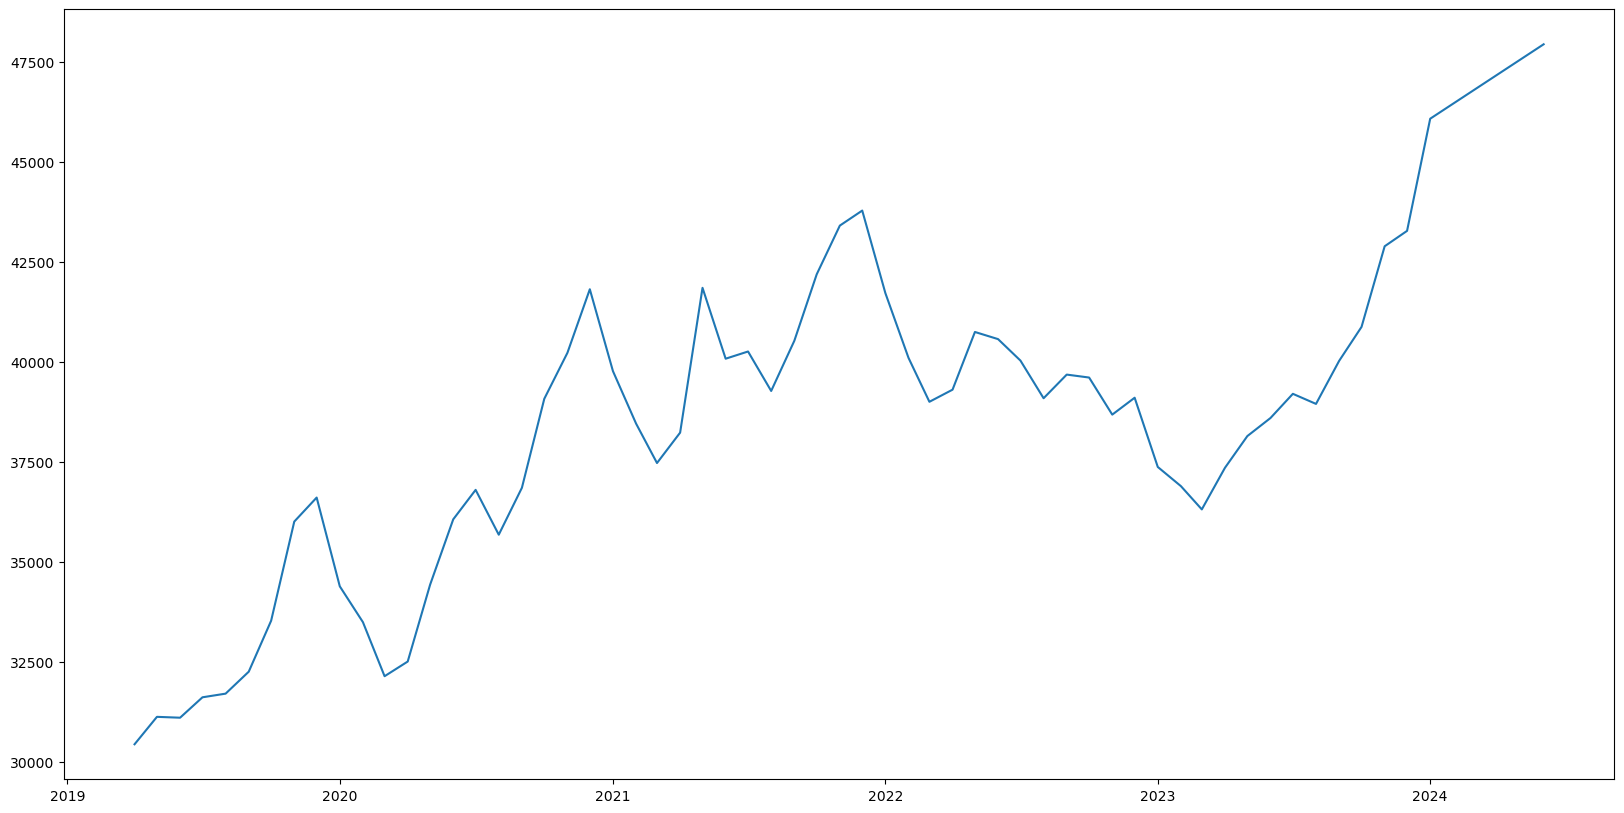

In [485]:
# deposit_mean 그래프 그리기
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
# datetime으로 변환
interest_rate_df['contract_year_month'] = pd.to_datetime(interest_rate_df['contract_year_month'], format='%Y%m')

plt.plot(interest_rate_df['contract_year_month'], interest_rate_df['deposit_mean'], label='deposit_mean')


In [488]:
# 두 날짜를 대입하면 변동 비율을 알 수 있는 함수 만들기.
def get_interest_rate_diff(start_date, end_date):
    start_value = interest_rate_df[interest_rate_df['contract_year_month'] == start_date]['deposit_mean'].values[0]
    end_value = interest_rate_df[interest_rate_df['contract_year_month'] == end_date]['deposit_mean'].values[0]
    return (end_value - start_value) / start_value

In [489]:
# 2019-04-01 에서 2024-06-01 까지 변동 비율을 전부 계산해서 dataframe으로 저장
interest_rate_diff_df = pd.DataFrame()
for date in interest_rate_df['contract_year_month'].unique():
    for date2 in interest_rate_df['contract_year_month'].unique():
        if date < date2:
            interest_rate_diff_df = pd.concat([interest_rate_diff_df, pd.DataFrame({'start_date': [date], 'end_date': [date2], 'interest_rate_diff': [get_interest_rate_diff(date, date2)]})])

In [494]:
# interest_rate_diff_df 에서 start_date, end_date 형식 YYYYMM으로 변환  
interest_rate_diff_df['start_date'] = interest_rate_diff_df['start_date'].dt.strftime('%Y%m')
interest_rate_diff_df['end_date'] = interest_rate_diff_df['end_date'].dt.strftime('%Y%m')

AttributeError: Can only use .dt accessor with datetimelike values

In [495]:
interest_rate_diff_df

,start_date,end_date,interest_rate_diff
0,201904,201905,0.022516
0,201904,201906,0.021804
0,201904,201907,0.038558
0,201904,201908,0.041556
0,201904,201909,0.059570
...,...,...,...
0,202403,202405,0.015945
0,202403,202406,0.024048
0,202404,202405,0.007779
0,202404,202406,0.015817


In [496]:
interest_rate_diff_df.to_csv('data/interest_rate_diff.csv', index=False)